# Reliability Curves

In machine learning, calibration is used to better calculate confidence intervals and prediction probabilities of a given model. Calibration is particularly useful in areas like decision trees or random forests where certain classifiers only give the label of the event and don’t support native probabilities or confidence intervals. When modelers want to be confident in their predictions, they can evaluate their model via calibration to check that the predicted class distributions are similar to the current class distributions.

Reliability curves plot the actuals/empirical probability against estimated/predicted probability. The calibration intercept, which is an assessment of calibration-in-the-large, has a target value of zero; values under the curve suggest overestimation, whereas values above the curve suggest underestimation. The better calibrated the model, the closer the points will lie on the diagonal line.

In this project, I used data from the UC Irvine Machine Learning Repository, specifically Ionosphere data which is a classification of radar returns from the ionosphere. I attempt to use LogistricRegression to get an initial calibration curve and then attempt to use a calibrated classifier to fit it closer to the diagonal line. A sigmoid was used because the original data showed a sigmoid shape.

### Assumptions

- Predicted probabilities are meaningful and comparable across samples.
- Evaluation data is representative of deployment data.
- The model outputs probabilistic predictions rather than only class labels.
- Sufficient data is available to estimate empirical frequencies reliably.

In [1]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, brier_score_loss

In [2]:
def _make_bins(values, n_bins=10, strategy="quantile"):
    """Return bin edges and bin index per value."""
    values = np.asarray(values, dtype=float)
    if strategy == "quantile":
        edges = np.quantile(values, np.linspace(0, 1, n_bins + 1))
        edges = np.unique(edges)  # quantiles can repeat if values are tied
        if len(edges) <= 2:       # degenerate case: all values identical
            edges = np.array([0.0, 1.0])
    elif strategy == "uniform":
        edges = np.linspace(0.0, 1.0, n_bins + 1)
    else:
        raise ValueError("strategy must be 'quantile' or 'uniform'")
    # Map each value to a bin in [1, len(edges)-1]
    bin_ids = np.digitize(values, edges, right=True)
    # Clip to valid range (can happen for value==1.0 with right=True)
    bin_ids = np.clip(bin_ids, 1, len(edges) - 1)
    return edges, bin_ids

def expected_calibration_error_binary(y_true, y_prob, n_bins=10, strategy="quantile", sample_weight=None):
    """
    ECE for binary classification using positive-class probability.
    Returns (ece, mce, per_bin) where per_bin is a list of dicts.
    """
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob, dtype=float)
    n = len(y_true)
    if sample_weight is None:
        sample_weight = np.ones(n)
    sample_weight = np.asarray(sample_weight, dtype=float)

    edges, bin_ids = _make_bins(y_prob, n_bins, strategy)

    per_bin = []
    ece = 0.0
    mce = 0.0
    for b in range(1, len(edges)):
        mask = bin_ids == b
        if not np.any(mask):
            continue
        w = sample_weight[mask]
        wsum = w.sum()
        conf = np.average(y_prob[mask], weights=w)
        acc  = np.average(y_true[mask], weights=w)
        gap  = abs(acc - conf)
        weight = wsum / sample_weight.sum()
        ece += weight * gap
        mce = max(mce, gap)
        per_bin.append({
            "bin": b,
            "left": edges[b-1],
            "right": edges[b],
            "n": int(mask.sum()),
            "weight": float(weight),
            "mean_confidence": float(conf),
            "accuracy": float(acc),
            "gap": float(gap),
        })
    return float(ece), float(mce), per_bin

In [3]:
# fetch dataset 
ionosphere = fetch_ucirepo(id=52) 
  
# data (as pandas dataframes) 
X = ionosphere.data.features 
y = ionosphere.data.targets["Class"].map({"g": 1, "b": 0}).astype(int)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
clf = LogisticRegression(max_iter= 500, random_state=42)
clf.fit(X_train, y_train.values.ravel())


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


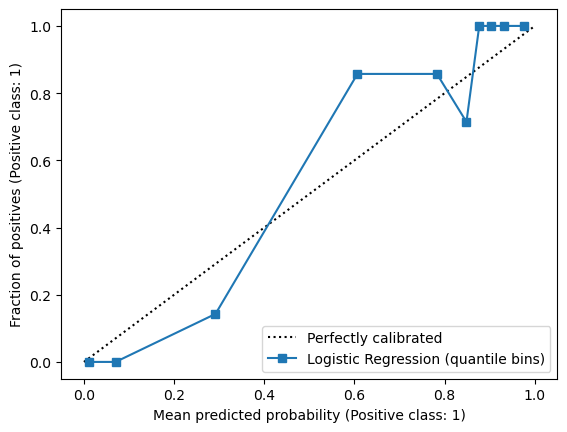

Brier Score: 0.06647333493393094


In [5]:
CalibrationDisplay.from_estimator(
    clf, X_test, y_test,
    n_bins=10,
    strategy="quantile",
    pos_label=1,
    name="Logistic Regression (quantile bins)"
)
plt.show()

pos_idx = list(clf.classes_).index(1)
y_prob = clf.predict_proba(X_test)[:, pos_idx]

bs = brier_score_loss(y_test, y_prob, pos_label=1)
print("Brier Score:", bs)

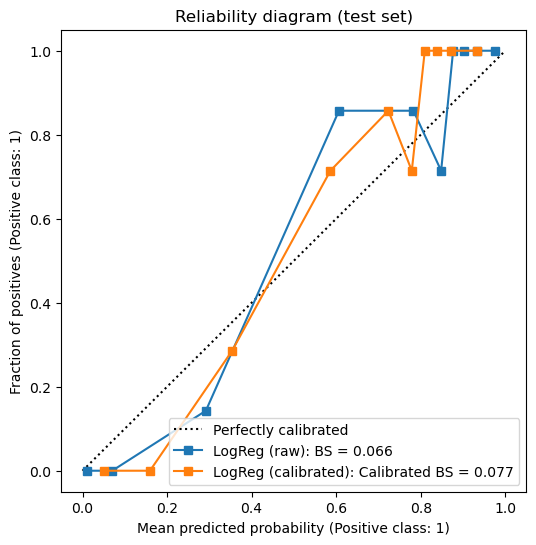

Calibrated Brier Score: 0.07728681601164676


In [6]:
calibrated_clf = CalibratedClassifierCV(estimator=clf, cv=5, method="sigmoid")
calibrated_clf.fit(X_train, y_train)

pos_idx_calibration = list(calibrated_clf.classes_).index(1)
calibrated_y_prob = calibrated_clf.predict_proba(X_test)[:, pos_idx_calibration]
calibrated_bs = brier_score_loss(y_test, calibrated_y_prob, pos_label=1)

fig, ax = plt.subplots(figsize=(6, 6))

CalibrationDisplay.from_estimator(
    clf, X_test, y_test,
    n_bins=10, strategy="quantile",
    pos_label=1, name=(f"LogReg (raw): BS = {bs:.3f}"),
    ax=ax
)

CalibrationDisplay.from_estimator(
    calibrated_clf, X_test, y_test,
    n_bins=10, strategy="quantile",
    pos_label=1, name=(f"LogReg (calibrated): Calibrated BS = {calibrated_bs:.3f}"),
    ax=ax
)

ax.set_title("Reliability diagram (test set)")
ax.legend(loc="lower right")
plt.show()

print("Calibrated Brier Score:", calibrated_bs)

In [7]:
ece, mce, bins = expected_calibration_error_binary(y_test, y_prob, n_bins=10, strategy="quantile")
print(f"ECE Before Calibration={ece:.4f}, MCE Before Calibration={mce:.4f}")

ece, mce, bins = expected_calibration_error_binary(y_test, calibrated_y_prob, n_bins=10, strategy="quantile")
print(f"ECE After Calibration={ece:.4f}, MCE After Calibration={mce:.4f}")

ECE Before Calibration=0.0988, MCE Before Calibration=0.2506
ECE After Calibration=0.1145, MCE After Calibration=0.1903


In [8]:
# predict the data
y_pred = clf.predict(X_test)
calibrated_y_pred = calibrated_clf.predict(X_test)

new_line = '\n'
print(f'Confusion Matrix for pre-calibration is:{new_line}{confusion_matrix(y_test, y_pred)}')

print(f"Confusion Matrix for post-calibration is:{new_line}{confusion_matrix(y_test, calibrated_y_pred)}")

Confusion Matrix for pre-calibration is:
[[21  4]
 [ 1 45]]
Confusion Matrix for post-calibration is:
[[20  5]
 [ 0 46]]


### Key takeaways

- Accuracy alone does not guarantee well-calibrated probabilities.
- Reliability curves visualise the alignment between predicted confidence and observed outcomes.
- A model can be accurate yet poorly calibrated.
- Calibration is critical in risk-sensitive applications such as healthcare and decision support.